# Data Analysis and Processing

## Setting up

In [1]:
# append root directory to path so we can import from `common` - in reality this would not be
# required as we would store the modules in `common` as some centrally managed library 

import sys
import os

notebook_root_dir = os.path.dirname(os.path.abspath(os.getcwd()))
sys.path.append(notebook_root_dir)

In [2]:
# do imports

import random

import pandas as pd
from matplotlib import pyplot as plt

from common.pre_processing import add_dynamic_columns, add_static_columns

In [3]:
# read in the data from excel

all_data = pd.read_excel("../data/2024_strat_case_study.xlsx", sheet_name=None)  # read all sheets in .xlsx file
static_data_raw = all_data["DATA-Static"]
month_end_balance_data_raw = all_data["DATA-Month End Balances"]
payment_due_data_raw = all_data["DATA-Payment Due"]
payment_made_data_raw = all_data["DATA-Payment Made"]

In [4]:
# reformat our data a bit

static_data = static_data_raw.iloc[1:, 1:]
static_data.columns = static_data.iloc[0, :]
static_data = static_data.iloc[1:, :]
static_data = static_data.set_index("loan_id")

month_end_balance_data = month_end_balance_data_raw.set_index("loan_id")
payment_due_data = payment_due_data_raw.rename(columns={"loan_Id": "loan_id"}).set_index("loan_id")
payment_made_data = payment_made_data_raw.set_index("loan_id")
    

In [18]:
static_data.describe().T

C:\Users\joelo\AppData\Local\Temp\ipykernel_25072\2671180689.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  static_data.describe().T
C:\Users\joelo\AppData\Local\Temp\ipykernel_25072\2671180689.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  static_data.describe().T
C:\Users\joelo\AppData\Local\Temp\ipykernel_25072\2671180689.py:1: FutureWarning: The behavior of value_counts with object-dtype is deprecated. In a future version, this will *not* perform dtype inference on the resulting index. To retain the old behavior, use `result.index = result.index.infer_objects()`
  static_data.describe().

,count,unique,top,freq
1,,,,
origination_date,1630,83,2022-12-31 00:00:00,57
investor_1_acquisition_date,1630,25,2020-12-31 00:00:00,749
reversion_date,1630,83,2024-12-31 00:00:00,57
original_balance,1630,1622,193067,2
product,1630,2,1,1246
pre_reversion_fixed_rate,1630.0,1630.0,0.047619,1.0
post_reversion_boe_margin,1630.0,2.0,0.0375,1246.0


In [19]:
static_data["product"].value_counts()

product
1    1246
2     384
Name: count, dtype: int64

In [21]:
static_data.groupby("product")["original_balance"].sum() / static_data["original_balance"].sum()

product
1    0.762018
2    0.237982
Name: original_balance, dtype: object

## Structural data checks

Perform quick structural checks on the data, and plot a few examples

In [5]:
def basic_data_checks(data: pd.DataFrame, name: str, expected_loans: set[str]) -> None:
    """
    plot basic sanity checking on the given data
    """

    global_min = data.min().min()
    global_max = data.max().max()
    missing_loans = expected_loans - set(data.index)
    additional_loans = set(data.index) - expected_loans
    duplicated_loans = data.index[data.index.duplicated()]

    print("=" * 50)
    print(f"SANITY CHECKING FOR {name}")
    print(f"Global min value: {global_min}")
    print(f"Global max value: {global_max}")
    print(f"Missing loans: {missing_loans}")
    print(f"Additional loans: {additional_loans}")
    print(f"Duplicated loans: {duplicated_loans}")

    fig, axs = plt.subplots(3, 2)
    fig.set_size_inches(20, 10)

    (data.isnull().sum() / data.shape[0]).plot(kind="line", ax=axs[0, 0], title="Null values (%)")
    data.min().plot(kind="line", ax=axs[0, 1], label="Min value", title="Min and max values")
    data.max().plot(kind="line", ax=axs[0, 1], label="Max value")
    axs[0, 1].legend()

    for i in range(4):
        row = 1 + (i // 2)
        col = i % 2
        n = random.randint(0, len(data) - 1)
        data.iloc[n, :].plot(kind="line", ax=axs[row, col], title=f"Plot for loan {data.index[n]}")

    fig.tight_layout()
        

    
    
    

SANITY CHECKING FOR Month End Balance Data
Global min value: 0.0
Global max value: 249978.0
Missing loans: set()
Additional loans: set()
Duplicated loans: Index([], dtype='int64', name='loan_id')


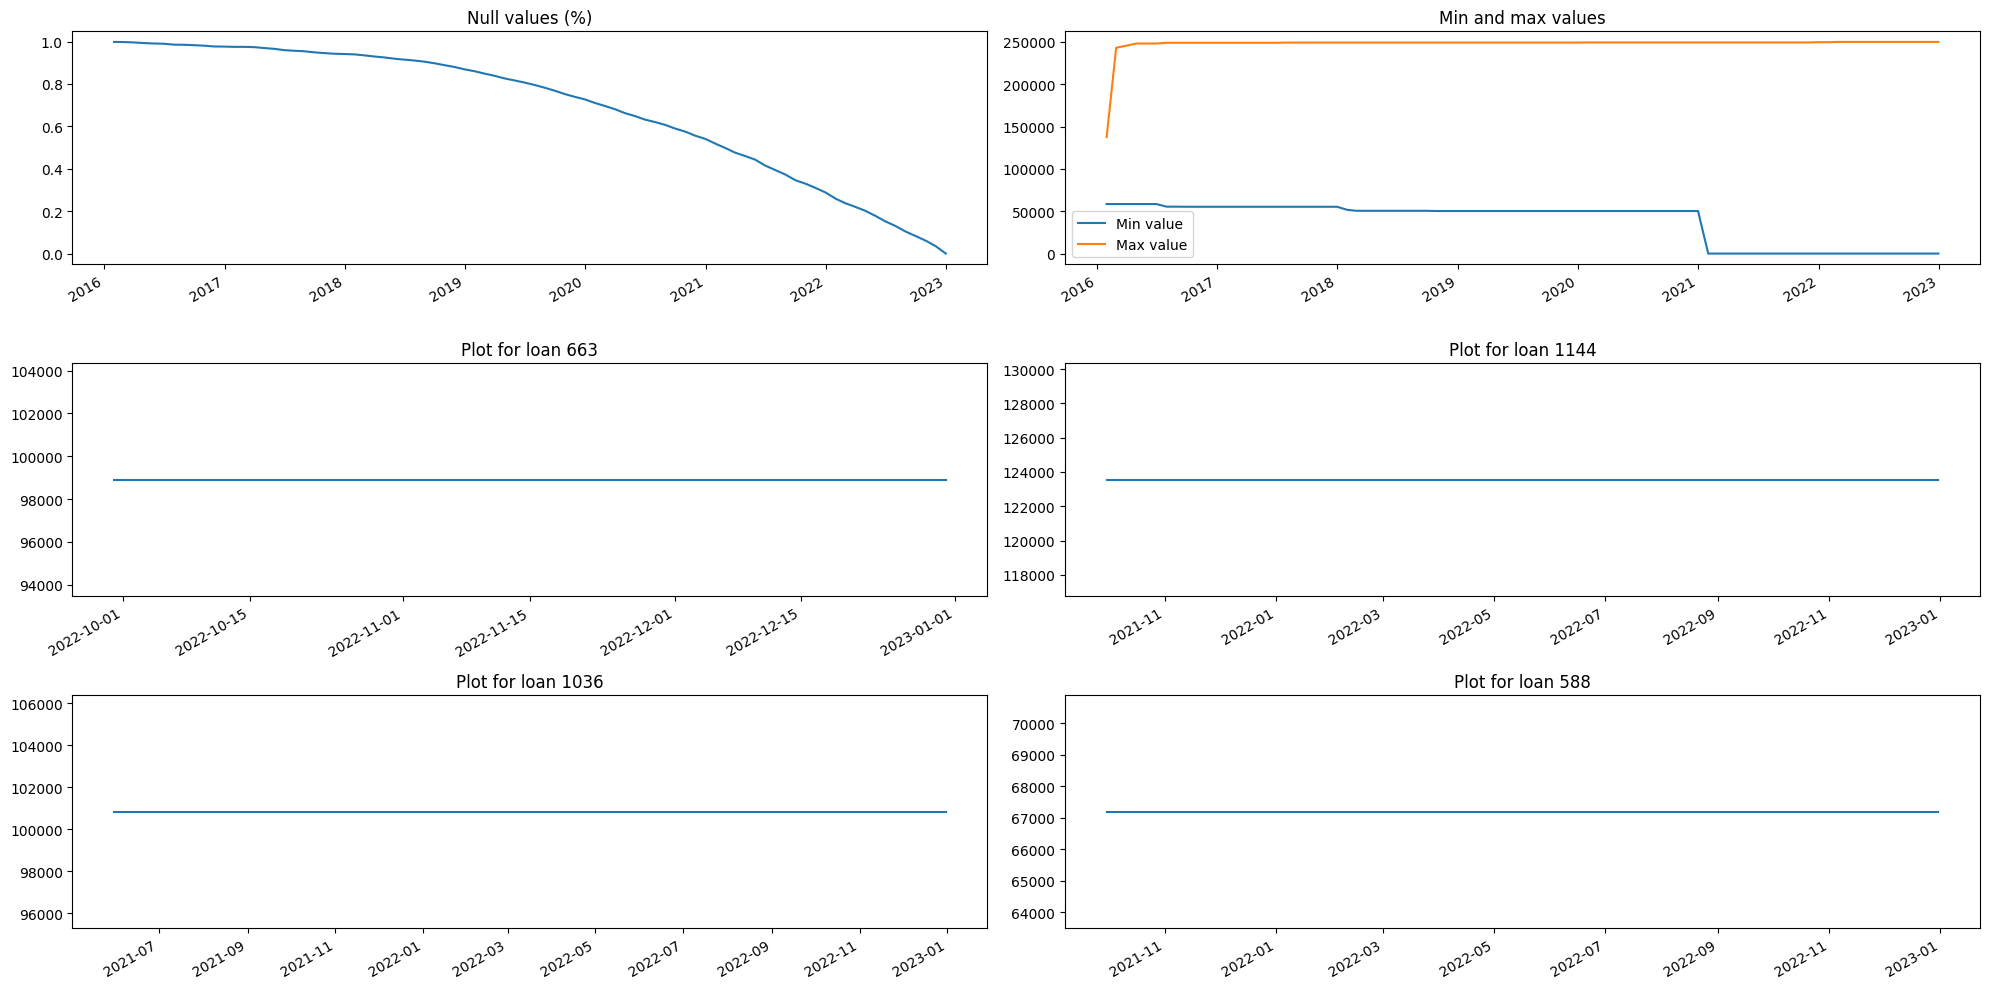

In [6]:
basic_data_checks(month_end_balance_data, "Month End Balance Data", set(static_data.index))

SANITY CHECKING FOR Payment Due Data
Global min value: 0.0
Global max value: 1536.20592038237
Missing loans: set()
Additional loans: set()
Duplicated loans: Index([], dtype='int64', name='loan_id')


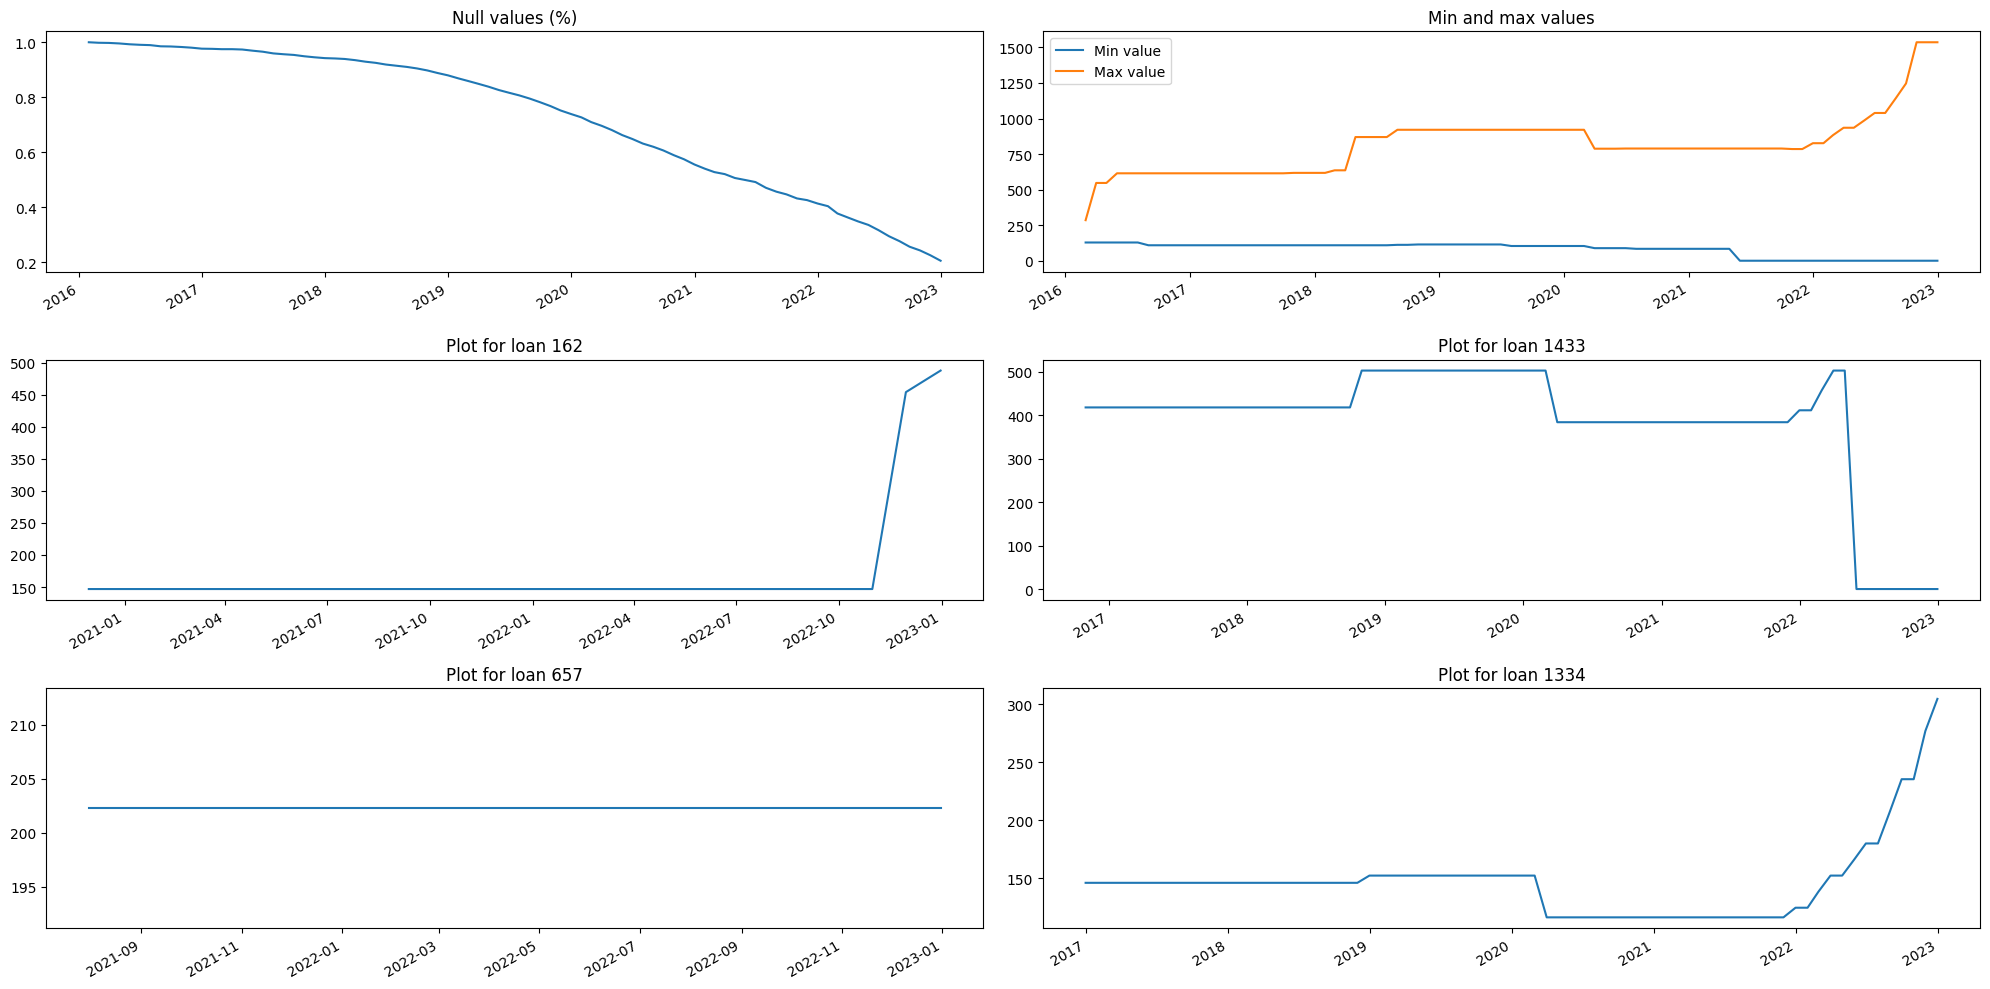

In [7]:
basic_data_checks(payment_due_data, "Payment Due Data", set(static_data.index))

SANITY CHECKING FOR Payment Made Data
Global min value: 0.0
Global max value: 248504.78375
Missing loans: set()
Additional loans: set()
Duplicated loans: Index([], dtype='int64', name='loan_id')


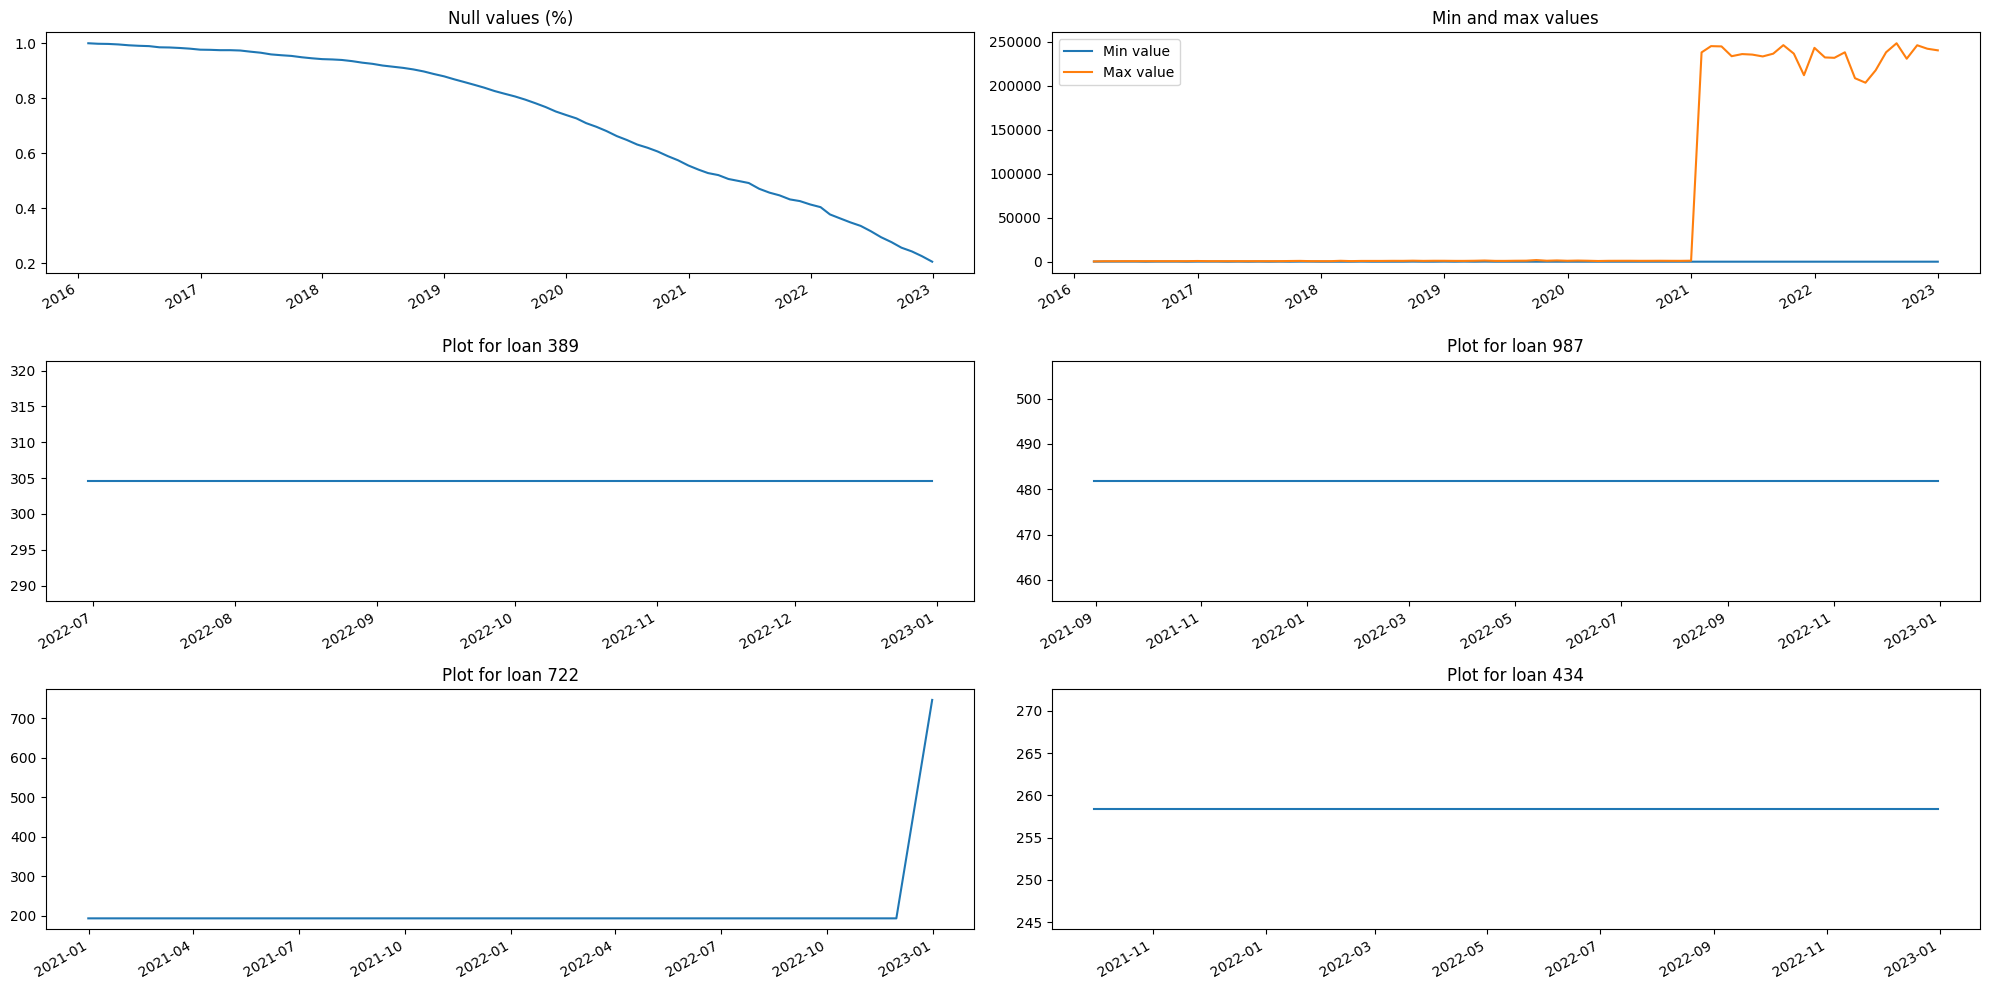

In [8]:
basic_data_checks(payment_made_data, "Payment Made Data", set(static_data.index))

## Data processing

Combine to a single data frame and add the required static/dynamic columns

In [9]:
# melt and combine data to single frame

processed_data = month_end_balance_data.reset_index().melt(id_vars="loan_id", var_name="date", value_name="month_end_balance")
melted_payment_due = payment_due_data.reset_index().melt(id_vars="loan_id", var_name="date", value_name="payment_due")
processed_data = pd.merge(processed_data, melted_payment_due, on=["loan_id", "date"])
melted_payment_made = payment_made_data.reset_index().melt(id_vars="loan_id", var_name="date", value_name="payment_made")
processed_data = pd.merge(processed_data, melted_payment_made, on=["loan_id", "date"])
processed_data = pd.merge(processed_data, static_data, on=["loan_id"])#
for d in ["date", "origination_date", "investor_1_acquisition_date", "reversion_date"]:
    processed_data[d] = pd.to_datetime(processed_data[d])

In [10]:
# add dynamica and static columns

# TODO: get rid of these annoying warnings

processed_data = processed_data.groupby("loan_id").apply(add_dynamic_columns, include_groups=False)
processed_data = processed_data.reset_index(level=0)
processed_data = processed_data.groupby("loan_id").apply(add_static_columns, include_groups=False)
processed_data = processed_data.reset_index(level=0)

C:\Users\joelo\python\mortgages-case-study\common\pre_processing.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  not_defaulted_so_far = ~(is_defaulted_this_month.shift(1).fillna(False))
C:\Users\joelo\python\mortgages-case-study\common\pre_processing.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  not_defaulted_so_far = ~(is_defaulted_this_month.shift(1).fillna(False))
C:\Users\joelo\python\mortgages-case-study\common\pre_processing.py:61: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in

In [11]:
# write date to csv to use in next steps
processed_data.to_csv("../data/processed_case_study_data.csv")